In [ ]:
import numpy as np

payoff = np.array([
    [[2, 2], [3, 0]],
    [[0, 3], [5, 5]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[player1_strategy, player2_strategy][player_id]

a =((get_payoff(0,0,0) - get_payoff(1,0,0)) / ((get_payoff(0,0,0) - get_payoff(1,0,0)) + (get_payoff(1,1,0) - get_payoff(0,1,0))))
a

In [19]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


# Reproducibility
np.random.seed(42)
random.seed(42)

payoff = np.array([
    [[2, 2], [3, 0]], 
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[player1_strategy, player2_strategy][player_id]

class StagHuntAgent:
    def __init__(self, u_i=None, t_init=1.0, eta=0.1, noise_sigma=0.02, discount_factor=0.9, trust_smoothing=0.1):
        self.x = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) / 
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) + 
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t = t_init
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.discount_factor = discount_factor
        self.trust_smoothing = trust_smoothing  # parameter for smoothing trust updates
        # Track history of matches for computing target trust
        self.match_history = []  # 1 if partner's choice matches expectation, 0 otherwise
    
    def expected_p(self):
        return (1 + self.x * self.t) / (2 + self.t)
    
    def make_decision(self):
        p = self.expected_p()
        E_V_hare = get_payoff(0, 0, 0) + p
        E_V_stag = get_payoff(1, 1, 0) * p
        D = E_V_stag - E_V_hare
        return 1 if D > 0 else 0
    
    def compute_new_trust(self, partner_choice):
        """Compute new trust by smoothing toward a target trust based on recent consistency."""
        # Expected choice based on current signal
        expected_choice = 1 if self.x > 0.5 else 0
        # Record whether the partner's choice matched the expectation
        match = 1 if partner_choice == expected_choice else 0
        self.match_history.append(match)
        
        # Compute target trust as a discounted average of matches
        if not self.match_history:
            target_trust = 1.0  # Initial target if no history
        else:
            weights = [self.discount_factor ** i for i in range(len(self.match_history)-1, -1, -1)]
            consistency = sum(m * w for m, w in zip(self.match_history, weights)) / sum(weights)
            # Map consistency (0 to 1) to target trust (1.0 to 5.0)
            target_trust = 1.0 + (5.0 - 1.0) * consistency
        
        # Smooth trust toward the target
        new_trust = (1 - self.trust_smoothing) * self.t + self.trust_smoothing * target_trust
        
        # Bound trust between 0.1 and 5.0
        return np.clip(new_trust, 0.1, 5.0)
    
    """ === SIMPLE EXAMPLE TO EXPLAIN TRUST CALCULATION ===

Imagine we observed the partner's behavior in 4 rounds:
match_history = [1, 0, 1, 1]  → 1 = matched expected behavior, 0 = didn't match

Let discount_factor = 0.9  → recent behavior is more important

So we assign weights to each round, from oldest to newest:
weights = [0.9^3, 0.9^2, 0.9^1, 0.9^0] = [0.729, 0.81, 0.9, 1.0]

Multiply each match by its weight:
Round 1: 1 × 0.729 = 0.729
Round 2: 0 × 0.81  = 0.0
Round 3: 1 × 0.9   = 0.9
Round 4: 1 × 1.0   = 1.0

Total weighted match score = 0.729 + 0.0 + 0.9 + 1.0 = 2.629
Total weights = 0.729 + 0.81 + 0.9 + 1.0 = 3.439

So consistency = 2.629 / 3.439 ≈ 0.764

This means the partner is about 76.4% consistent (with more recent behavior counting more).

Then we convert this consistency into target trust:
target_trust = 1.0 + (5.0 - 1.0) * consistency
             = 1.0 + 4.0 * 0.764 ≈ 4.06

Finally, we update the current trust smoothly toward 4.06, depending on how quickly we want it to change
(using a "trust_smoothing" factor like 0.1 or 0.2) """

    def compute_new_signal(self, P_obs):
        noise = np.random.normal(0, self.noise_sigma)
        return np.clip(self.x + self.eta * (P_obs - self.x) + noise, 0, 1)
    
    def update_state(self, new_trust, new_signal):
        self.t = new_trust
        self.x = new_signal

def always_collaborate():
    return 1

def always_defect():
    return 0

def tit_for_tat_cooperate(last_agent_choice=1):
    return last_agent_choice  

def tit_for_tat_defect(last_agent_choice=0):
    return last_agent_choice  

def adaptive_strategy(agent):
    return 1 if agent.x > 0.5 else 0  

def random_strategy():
    return random.choice([0, 1])

def cheating_partner(round_num, cycle_length=6, cheat_duration=2):
    return 1 if (round_num % (cycle_length + cheat_duration)) < cycle_length else 0

def cheating_partner_cycle(round_num, cycle_length_1=30):
    # cooperate for cycle_length rounds, then defect for cheat_duration rounds (repeating)
    return 1 if (round_num < cycle_length_1) else 0

def probabilistic_cheater():
    return 1 if random.random() < 0.7 else 0

def strategic_cheater(agent):
    return 0 if agent.t > 2.5 else 1

def expectation_violation_cheater(agent):
    """A partner that cheats by doing the opposite of what the agent expects."""
    return 0 if agent.x > 0.5 else 1

def run_single_agent_simulation(u_i, num_rounds=20, strategy=always_collaborate, initial_last_choice=1, strategy_kwargs={}, discount_factor=0.9, trust_smoothing=0.1):
    agent = StagHuntAgent(u_i=u_i, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
    results = []
    last_agent_choice = initial_last_choice
    partner_choices = []
    
    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()
        
        if strategy in [tit_for_tat_cooperate, tit_for_tat_defect]:
            partner_choice = strategy(last_agent_choice)
        elif strategy in [adaptive_strategy, strategic_cheater, expectation_violation_cheater]:
            partner_choice = strategy(agent)
        elif strategy == cheating_partner:
            partner_choice = strategy(round_num, **strategy_kwargs)
        elif strategy == cheating_partner_cycle:
            partner_choice = strategy(round_num, **strategy_kwargs)
        else:
            partner_choice = strategy()
        
        partner_choices.append(partner_choice)

        P_obs = sum(partner_choices) / len(partner_choices) if partner_choices else agent.x
        if discount_factor is not None:
            weights = [discount_factor ** i for i in range(len(partner_choices)-1, -1, -1)]
            P_obs = sum(p * w for p, w in zip(partner_choices, weights)) / sum(weights) if partner_choices else agent.x

        new_trust = agent.compute_new_trust(partner_choice)
        new_signal = agent.compute_new_signal(P_obs)

        agent.update_state(new_trust, new_signal)

        last_agent_choice = agent_choice
        results.append((round_num + 1, agent_choice, partner_choice, agent.x, agent.t))
    
    return results

# Set simulation parameters
num_rounds = 70  # Changed from 20 to test flexibility
discount_factor = 0.6  # Add discounted memory with a mild effect
trust_smoothing = 0.1  # New parameter

# Run simulations with all strategies
sim_results_cheating = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=cheating_partner, strategy_kwargs={"cycle_length": 6, "cheat_duration": 2}, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_cheating_partner_cycle = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=cheating_partner_cycle, strategy_kwargs={"cycle_length_1": 30}, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_strategic_cheater = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=strategic_cheater, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_prob_cheater = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=probabilistic_cheater, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_tit_for_tat_coop = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=tit_for_tat_cooperate, initial_last_choice=1, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_tit_for_tat_defect = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=tit_for_tat_defect, initial_last_choice=0, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_collab = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=always_collaborate, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_defect = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=always_defect, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_random = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=random_strategy, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_adaptive = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=adaptive_strategy, discount_factor=discount_factor, trust_smoothing=trust_smoothing)
sim_results_expect_violation = run_single_agent_simulation(u_i=None, num_rounds=num_rounds, strategy=expectation_violation_cheater, discount_factor=discount_factor, trust_smoothing=trust_smoothing)

# Convert to DataFrames
df_cheating = pd.DataFrame(sim_results_cheating, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_cheating_partner_cycle = pd.DataFrame(sim_results_cheating_partner_cycle, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_strategic_cheater = pd.DataFrame(sim_results_strategic_cheater, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_prob_cheater = pd.DataFrame(sim_results_prob_cheater, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_collab = pd.DataFrame(sim_results_collab, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_defect = pd.DataFrame(sim_results_defect, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_random = pd.DataFrame(sim_results_random, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_tit_for_tat_coop = pd.DataFrame(sim_results_tit_for_tat_coop, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_tit_for_tat_defect = pd.DataFrame(sim_results_tit_for_tat_defect, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_adaptive = pd.DataFrame(sim_results_adaptive, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])
df_expect_violation = pd.DataFrame(sim_results_expect_violation, columns=["Round", "Agent_Choice", "Partner_Choice", "Agent_Signal", "Agent_Trust"])

In [20]:
df_cheating

,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust
0,1,0,1,0.409934,1.000000
1,2,0,1,0.466176,1.000000
2,3,0,1,0.532512,1.000000
3,4,0,1,0.609721,1.183824
4,5,0,1,0.644066,1.443026
...,...,...,...,...,...
65,66,0,1,0.724413,3.885781
66,67,0,1,0.736471,3.940962
67,68,0,1,0.774458,4.013122
68,69,1,1,0.799184,4.091563


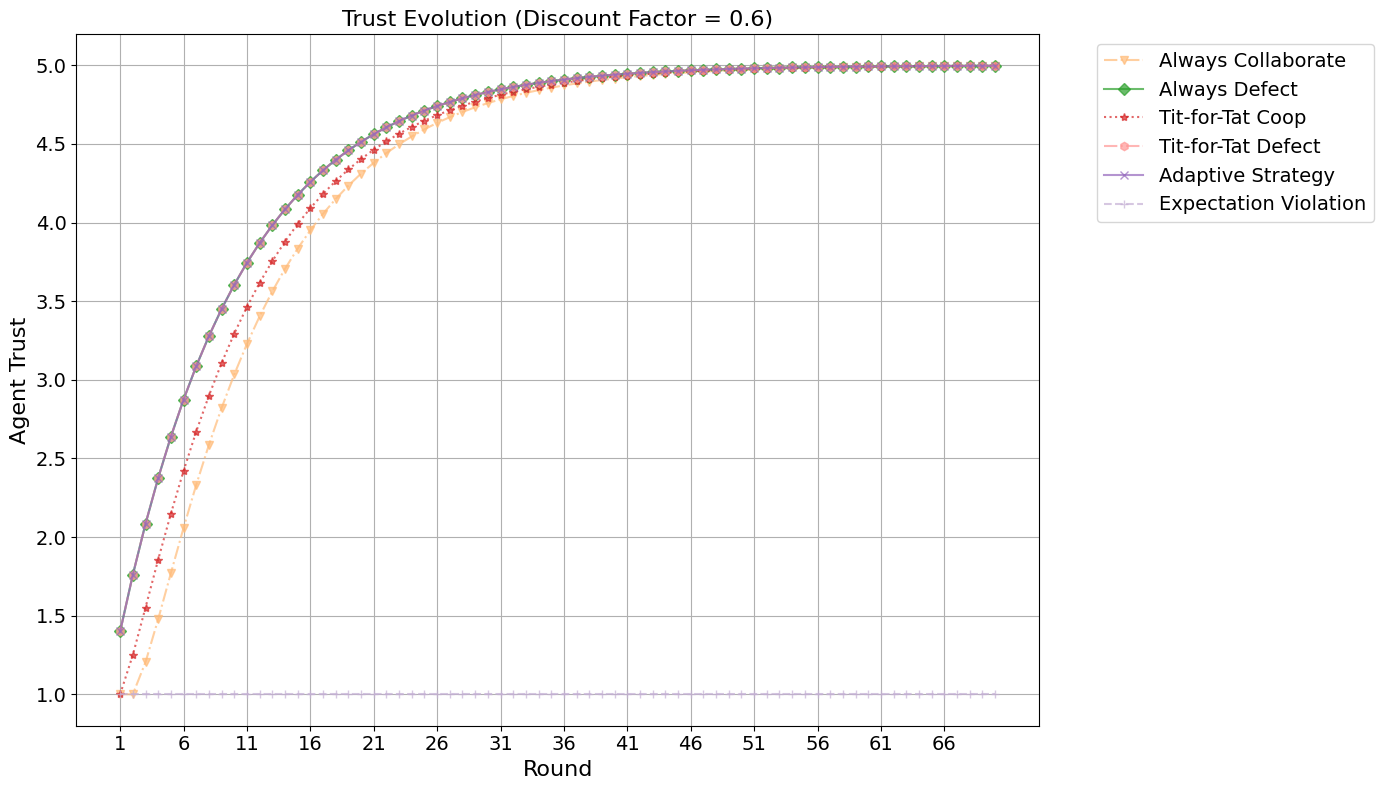

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a distinct color palette (using seaborn's "tab10" or "tab20" for more colors)
colors = sns.color_palette("tab20", 10)  # 10 distinct colors for 10 strategies

# Define line styles and markers to differentiate the lines
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# Visualize Trust Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Trust"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Trust"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Trust"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Trust"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Trust"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Trust"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

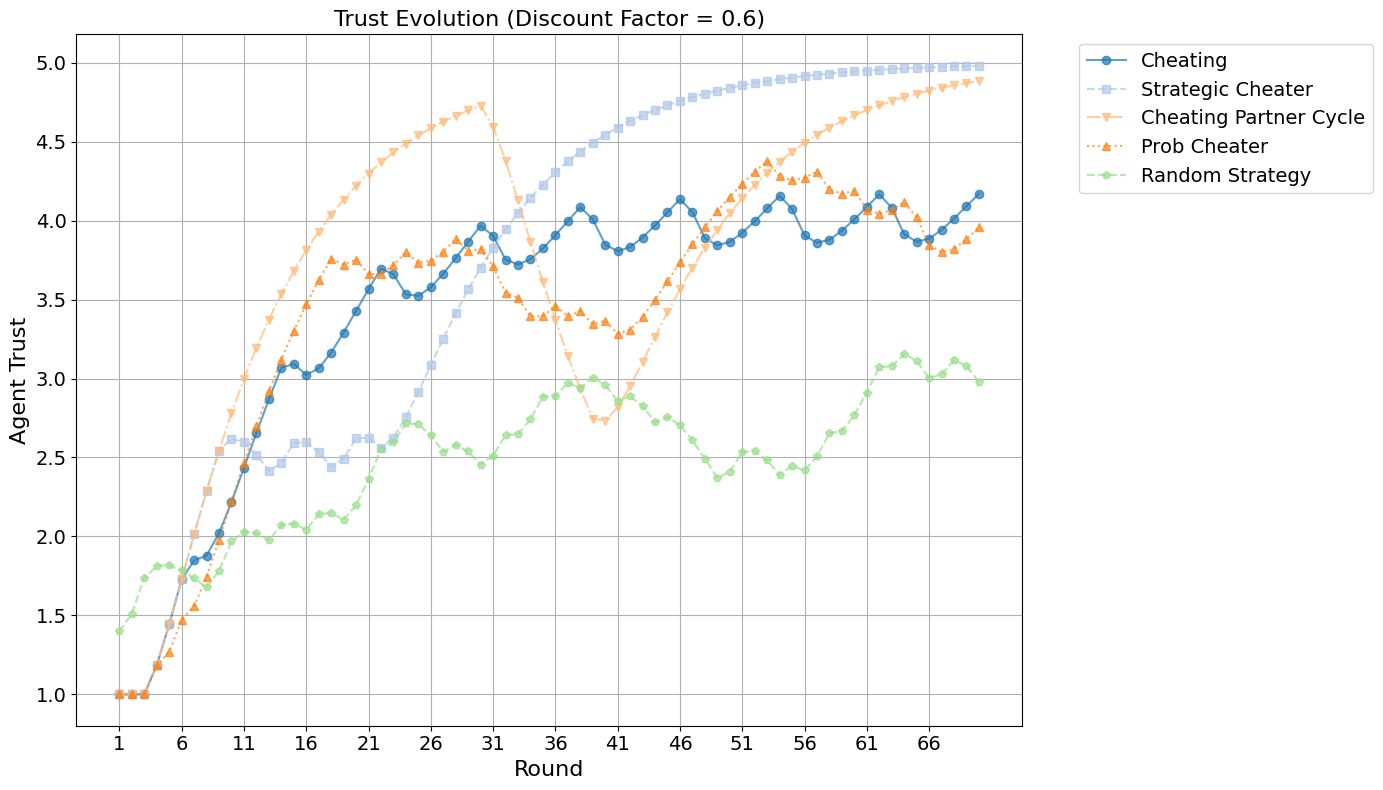

In [22]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Trust"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Trust"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Trust"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Trust"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Trust"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

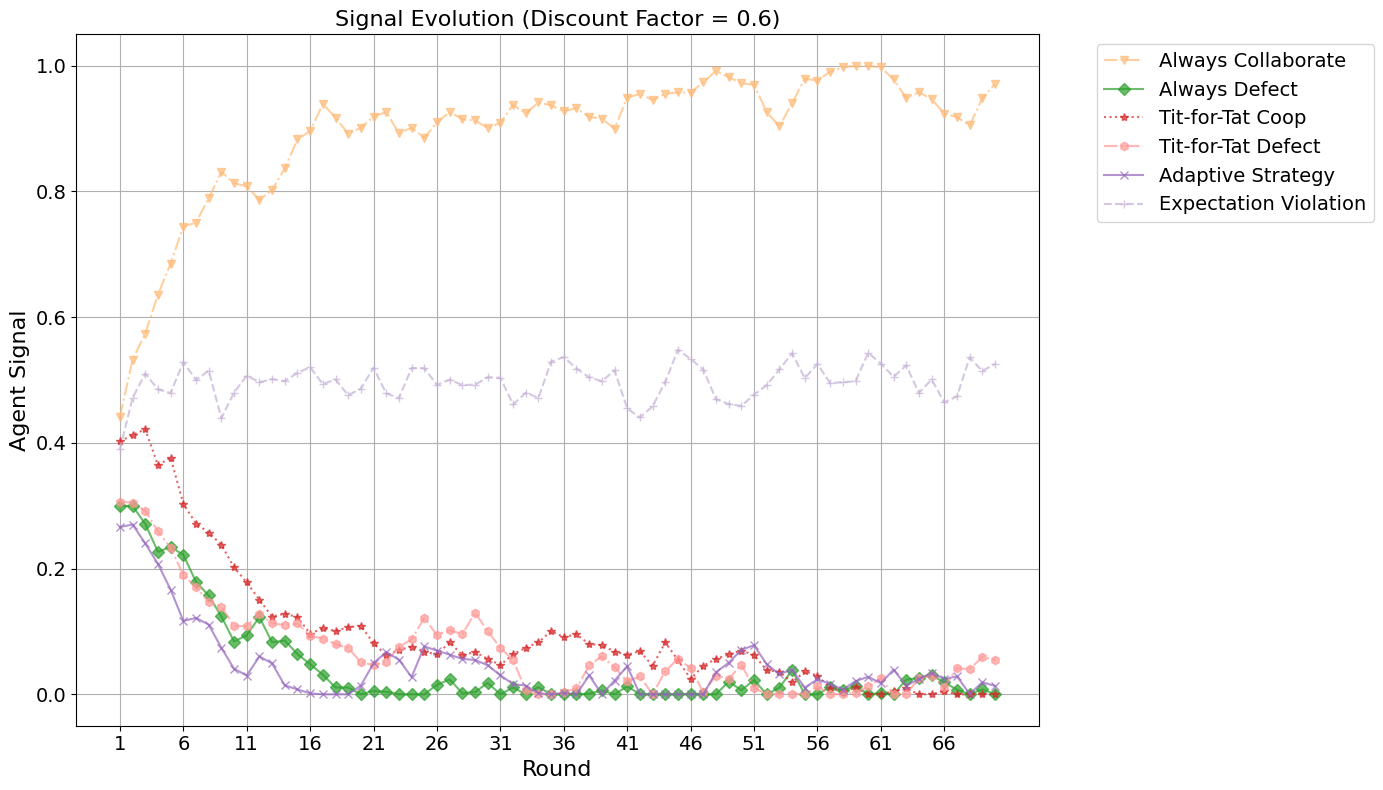

In [23]:

# Visualize Signal Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Signal"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Signal"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Signal"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Signal"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Signal"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Signal"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)


plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

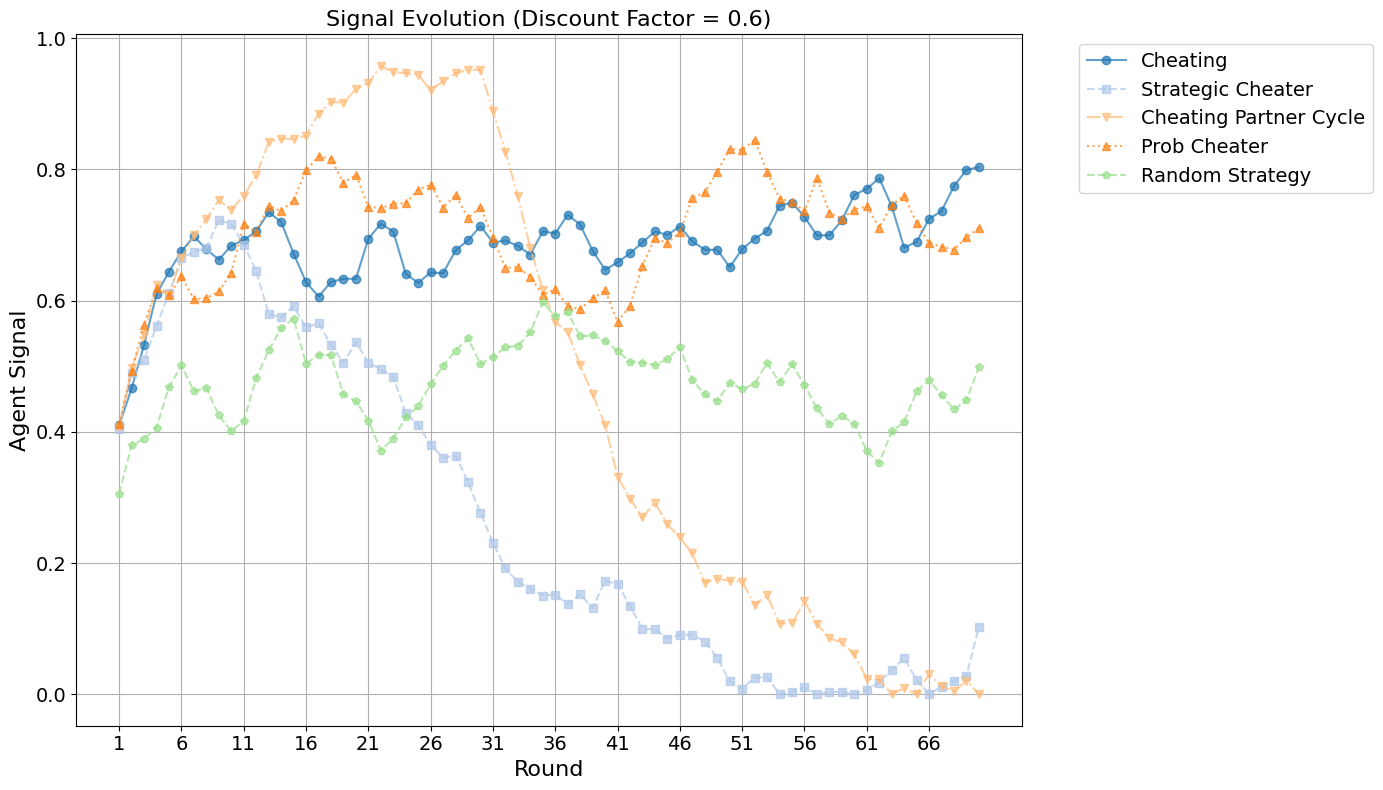

In [24]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Signal"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Signal"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Signal"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Signal"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Signal"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

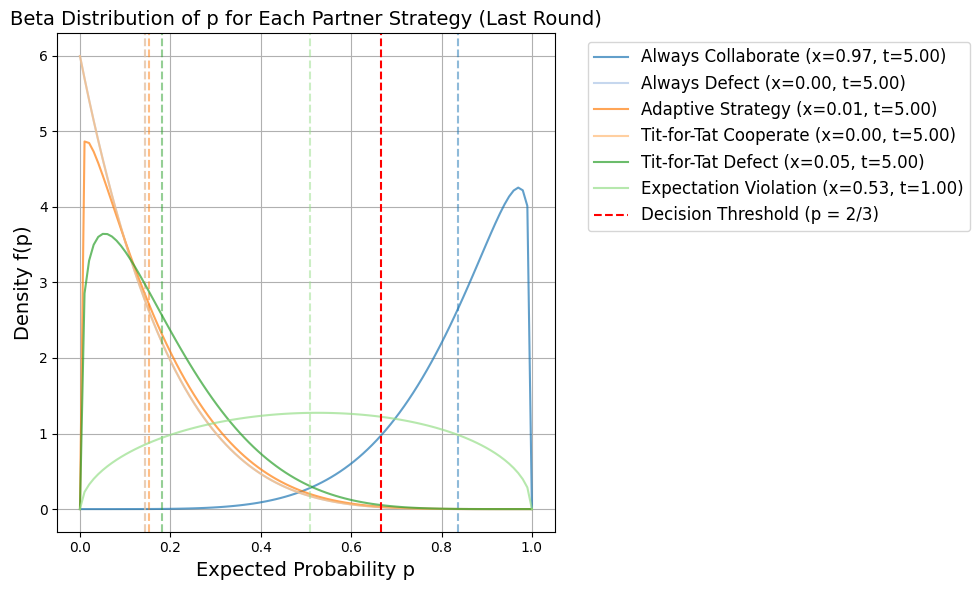

Decision-Making Trends in the Last Round:
Always Collaborate: p = 0.836, Choice = Stag
Always Defect: p = 0.143, Choice = Hare
Adaptive Strategy: p = 0.152, Choice = Hare
Tit-for-Tat Cooperate: p = 0.143, Choice = Hare
Tit-for-Tat Defect: p = 0.182, Choice = Hare
Expectation Violation: p = 0.509, Choice = Hare


In [25]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# List of DataFrames and their corresponding strategy names
strategies = [
    ("Always Collaborate", df_collab),
    ("Always Defect", df_defect),
    ("Adaptive Strategy", df_adaptive),
    ("Tit-for-Tat Cooperate", df_tit_for_tat_coop),
    ("Tit-for-Tat Defect", df_tit_for_tat_defect),
    ("Expectation Violation", df_expect_violation)
]

# Get x and t from the last round for each strategy
last_round_data = {}
for name, df in strategies:
    last_row = df.iloc[-1]  # Last round
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# Plot the Beta distribution of p for each strategy
p = np.linspace(0, 1, 100)  # Values of p from 0 to 1
plt.figure(figsize=(10, 6))

# Use the same colors as in your previous plots for consistency
colors = sns.color_palette("tab20", 10)

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute α and β
    alpha = 1 + x * t
    beta = 1 + (1 - x) * t
    # Compute the mean E[p]
    E_p = (1 + x * t) / (2 + t)
    # Plot the Beta distribution
    plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"{name} (x={x:.2f}, t={t:.2f})",
             color=colors[idx], alpha=0.7)
    # Mark the mean E[p] with a vertical line
    plt.axvline(x=E_p, color=colors[idx], linestyle='--', alpha=0.5)
# Add the decision threshold
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Beta Distribution of p for Each Partner Strategy (Last Round)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Compare with decision-making trends
print("Decision-Making Trends in the Last Round:")
for name, df in strategies:
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_p = (1 + df.iloc[-1]["Agent_Signal"] * df.iloc[-1]["Agent_Trust"]) / (2 + df.iloc[-1]["Agent_Trust"])
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

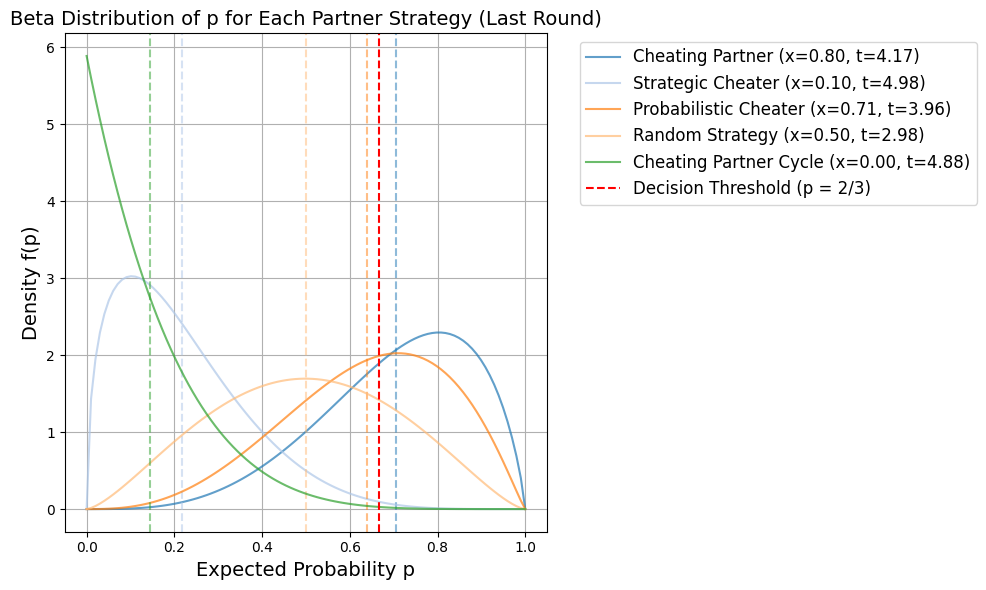

Decision-Making Trends in the Last Round:
Cheating Partner: p = 0.705, Choice = Stag
Strategic Cheater: p = 0.217, Choice = Hare
Probabilistic Cheater: p = 0.640, Choice = Hare
Random Strategy: p = 0.499, Choice = Hare
Cheating Partner Cycle: p = 0.145, Choice = Hare


In [26]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# List of DataFrames and their corresponding strategy names
strategies = [
    ("Cheating Partner", df_cheating),
    ("Strategic Cheater", df_strategic_cheater),
    ("Probabilistic Cheater", df_prob_cheater),
    ("Random Strategy", df_random),
    ("Cheating Partner Cycle", df_cheating_partner_cycle)

]

# Get x and t from the last round for each strategy
last_round_data = {}
for name, df in strategies:
    last_row = df.iloc[-1]  # Last round
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# Plot the Beta distribution of p for each strategy
p = np.linspace(0, 1, 100)  # Values of p from 0 to 1
plt.figure(figsize=(10, 6))

# Use the same colors as in your previous plots for consistency
colors = sns.color_palette("tab20", 10)

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute α and β
    alpha = 1 + x * t
    beta = 1 + (1 - x) * t
    # Compute the mean E[p]
    E_p = (1 + x * t) / (2 + t)
    # Plot the Beta distribution
    plt.plot(p, stats.beta.pdf(p, alpha, beta), label=f"{name} (x={x:.2f}, t={t:.2f})",
             color=colors[idx], alpha=0.7)
    # Mark the mean E[p] with a vertical line
    plt.axvline(x=E_p, color=colors[idx], linestyle='--', alpha=0.5)

# Add the decision threshold
plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')

plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Beta Distribution of p for Each Partner Strategy (Last Round)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Compare with decision-making trends
print("Decision-Making Trends in the Last Round:")
for name, df in strategies:
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_p = (1 + df.iloc[-1]["Agent_Signal"] * df.iloc[-1]["Agent_Trust"]) / (2 + df.iloc[-1]["Agent_Trust"])
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

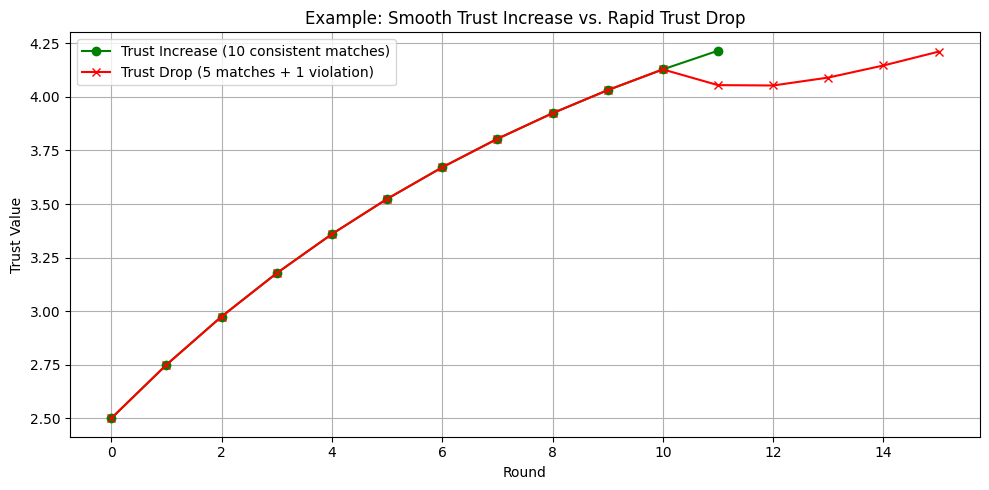

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
initial_trust = 2.5
trust_smoothing = 0.1
discount_factor = 0.6

# Trust evolution function
def compute_trust_evolution(match_history, initial_trust, discount_factor, trust_smoothing):
    trust = initial_trust
    trust_values = [trust]
    for t in range(len(match_history)):
        weights = [discount_factor ** i for i in range(t, -1, -1)]
        matches = match_history[:t+1]
        consistency = sum(m * w for m, w in zip(matches, weights)) / sum(weights)
        target_trust = 1.0 + (5.0 - 1.0) * consistency
        trust = (1 - trust_smoothing) * trust + trust_smoothing * target_trust
        trust_values.append(trust)
    return trust_values

# Case 1: Smooth Trust Increase
match_history_increase = [1] * 11  # 10 matches
trust_inc = compute_trust_evolution(match_history_increase, initial_trust, discount_factor, trust_smoothing)

# Case 2: Rapid Trust Drop
match_history_drop = [1] * 10 + [0] + [1] + [1] + [1] + [1]
trust_drop = compute_trust_evolution(match_history_drop, initial_trust, discount_factor, trust_smoothing)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trust_inc, label="Trust Increase (10 consistent matches)", marker='o', color='green')
plt.plot(trust_drop, label="Trust Drop (5 matches + 1 violation)", marker='x', color='red')
plt.xlabel("Round")
plt.ylabel("Trust Value")
plt.title("Example: Smooth Trust Increase vs. Rapid Trust Drop")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
